In [1]:
import pandas as pd

wine = pd.read_csv('/Users/fatehkaran/datasets/winequality-white.csv', sep=';')

In [2]:
wine.loc[(wine.quality <= 5),'quality']= 0
wine.loc[(wine.quality > 5),'quality']= 1

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [4]:
allData = wine


# Use the following code to select ALL features
X = wine.drop(columns='quality')  # Data Matrix containing all features excluding the target

target = wine['quality']

y = target.astype(np.int)   # 1D targer vector

X = X.values
y = y.values

In [5]:
print(X.shape)
print(y.shape)

(4898, 11)
(4898,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
%%time
# Set the the range of K 
neighbors = np.arange(1,60)

# Two arrays to store training and test accuracies
train_accuracy = np.empty(len(neighbors))
validation_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    
    # The "score" function returns the mean accuracy on the given train/test data and labels.
    # Note that "accuracy" may not be a good performance measure in a skewed data set
    # Thus, we need to do hyperparameter tuning by using better performance measures (e.g., f1 score, presision, recall)
    
    # Compute training accuracy 
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute validation accuracy using cross-validation
    
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    
    validation_accuracy[i] = scores.mean()

CPU times: user 26.3 s, sys: 203 ms, total: 26.5 s
Wall time: 26.6 s


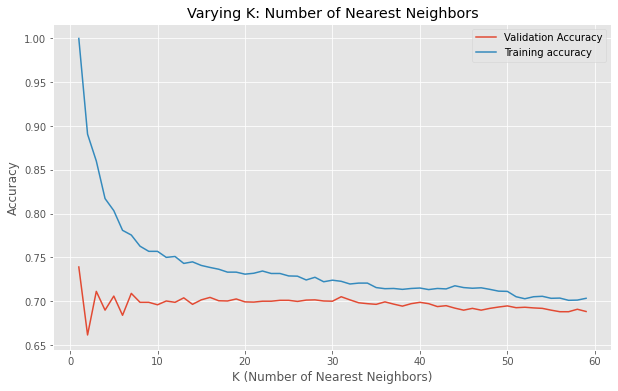

Optimal K:  1


In [10]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Varying K: Number of Nearest Neighbors')
plt.plot(neighbors, validation_accuracy, label='Validation Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.show()



# Find the value of "K" that gives max validation accuracy
j = 0
max_val_accuracy = validation_accuracy[j]
max_k = 1

for i in neighbors:
    if(validation_accuracy[j] > max_val_accuracy):
        max_val_accuracy = validation_accuracy[j]
        max_k = i
    j +=1
    
print("Optimal K: ", max_k)

In [11]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,50), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 686 candidates, totalling 3430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2508 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:  4.6min


Best Score: 0.850181
Optimal Hyperparameter Values:  {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}


CPU times: user 6.22 s, sys: 796 ms, total: 7.02 s
Wall time: 5min


[Parallel(n_jobs=-1)]: Done 3430 out of 3430 | elapsed:  5.0min finished


In [12]:
# With the Mahalanobis distance metric only the brute force algorithm works
#knn = KNeighborsClassifier(weights=?, algorithm='brute', n_neighbors=?, metric = "mahalanobis", metric_params= {'V': ?})

# Minkowski distance metric based optimal model selected via hyperparameter tuning.
# The Minkowski distance based model (i.e., knn_cv) is already trained with the optimal hyperparameter values.
# We can use the optimal model (knn_cv) for prediction.
# Or we can use the optimal hyperparameter values to train a new model, as follows.

knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  1.0


In [13]:
# random indices for three data points from the training dataset
data1Index = 340
data2Index = 1400
data3Index = 2727

y_train_predicted_1 = knn.predict(X_train[data1Index].reshape(1, -1))
print("\nPredicted Class for the first data: %d" % y_train_predicted_1)

y_train_predicted_proba_1 = knn.predict_proba(X_train[data1Index].reshape(1, -1))
print("Predicted Class Probabilities for the first data: ", y_train_predicted_proba_1)


y_train_predicted_2 = knn.predict(X_train[data2Index].reshape(1, -1))
print("\nPredicted Class for the second data: %d" % y_train_predicted_2)

y_train_predicted_proba_2 = knn.predict_proba(X_train[data2Index].reshape(1, -1))
print("Predicted Class Probabilities for the second data: ", y_train_predicted_proba_2)



y_train_predicted_3 = knn.predict(X_train[data3Index].reshape(1, -1))
print("\nPredicted Class for the second data: %d" % y_train_predicted_3)

y_train_predicted_proba_3 = knn.predict_proba(X_train[data3Index].reshape(1, -1))
print("Predicted Class Probabilities for the second data: ", y_train_predicted_proba_3)


Predicted Class for the first data: 1
Predicted Class Probabilities for the first data:  [[0. 1.]]

Predicted Class for the second data: 1
Predicted Class Probabilities for the second data:  [[0. 1.]]

Predicted Class for the second data: 1
Predicted Class Probabilities for the second data:  [[0. 1.]]


In [14]:
# indices for two data points from the training dataset
data4Index = 243
data5Index = 350


y_train_predicted_proba_4 = knn.predict_proba(X_train[data4Index].reshape(1, -1))
print("\nPredicted Class Probabilities for the first data: ", y_train_predicted_proba_4)

y_train_predicted_4 = knn.predict(X_train[data4Index].reshape(1, -1))
print("Predicted Class for the first data: %d" % y_train_predicted_4)


y_train_predicted_proba_5 = knn.predict_proba(X_train[data5Index].reshape(1, -1))
print("\nPredicted Class Probabilities for the second data: ", y_train_predicted_proba_5)

y_train_predicted_5 = knn.predict(X_train[data5Index].reshape(1, -1))
print("Predicted Class for the second data: %d" % y_train_predicted_5)


Predicted Class Probabilities for the first data:  [[0. 1.]]
Predicted Class for the first data: 1

Predicted Class Probabilities for the second data:  [[0. 1.]]
Predicted Class for the second data: 1


In [15]:
# Scoring Parameter for Classification:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# Note: For a skewed data set "accuracy" might not be a good choice for scoring
scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
print(scores)

print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.84448306 0.85862069 0.83716814 0.86367634 0.84695652]
F1 Score: 0.85 (+/- 0.02)


In [16]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[ 625,  660],
       [ 198, 2435]])

In [17]:
precision = precision_score(y_train, y_train_pred) 
print("Precision = %f" % precision)

recall = recall_score(y_train, y_train_pred)
print("Recall = %f" % recall)


f1 = f1_score(y_train, y_train_pred)
print("F1 Score = %f" % f1)

Precision = 0.786753
Recall = 0.924801
F1 Score = 0.850209


In [18]:
# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=5)[:, 1]


fpr, tpr, thresholds = roc_curve(y_train, y_scores)

print("\nFPR FPR & TPR for Various Threshold Values:")

print("FPR: ", fpr)
print("TPR: ", tpr)
print("\nThresholds: ", thresholds)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.00155642 0.00155642 ... 0.75875486 0.77276265 1.        ]
TPR:  [0.         0.27307254 0.27687049 ... 1.         1.         1.        ]

Thresholds:  [2.         1.         0.97789261 ... 0.19018986 0.06567589 0.        ]


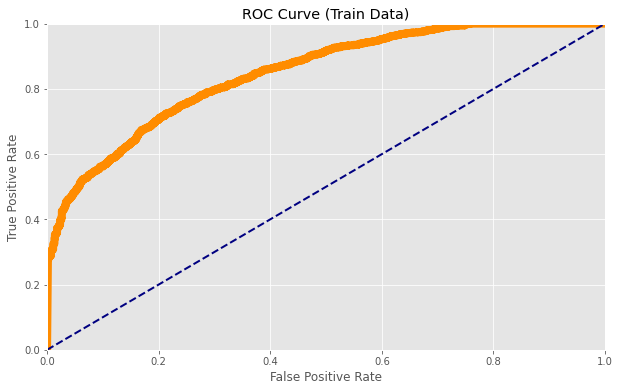

In [19]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [20]:
# Area under ROC curve
roc_auc_score(y_train,y_scores)

0.8466565486543881

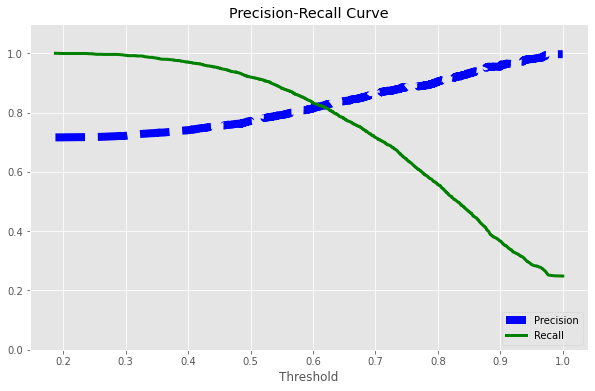

Optimal Threshold:  0.6133862354295622


In [21]:
plt.style.use('ggplot')

# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    #plt.xlim([0, 1])
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

In [22]:
print("Performance Measures Based on the Default Threshold:\n")


y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_train = precision_score(y_train, y_train_pred) 
print("Precision (Default Threshold 0.5) = %f" % precision_train)

recall_train = recall_score(y_train, y_train_pred)
print("Recall (Default Threshold 0.5) = %f" % recall_train)


f1_train = f1_score(y_train, y_train_pred)
print("F1 Score (Default Threshold 0.5) = %f" % f1_train)

print("Confusion Matrix (Default Threshold 0.5)\n", confusion_matrix(y_train, y_train_pred))


print("\n-------------------------------------------------------\n")
print("Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):")

# Precision, Recall, F1 Score and Confusion Matrix for different threshold

t = threshold_optimal # optimal threshold from precision-recall curve 

# Compute predictions based on new t by using the following method:
#  - Get the probability of the positive class from the 2nd column [:, 1]
#  - If that probability is greater than or equal to t, then the test data belongs to the positive class
y_train_predicted_new = (cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:,1] > t).astype(int)


precision = precision_score(y_train, y_train_predicted_new) 
print("\nPrecision (Threshold %.2f) = %f" % (t, precision))

recall = recall_score(y_train, y_train_predicted_new)
print("Recall (Threshold %.2f) = %f" % (t, recall))


f1 = f1_score(y_train, y_train_predicted_new)
print("F1 Score = (Threshold %.2f) = %f" % (t, f1))


print("Confusion Matrix (Threshold %.2f)" %  t) 
print(confusion_matrix(y_train, y_train_predicted_new))

Performance Measures Based on the Default Threshold:

Precision (Default Threshold 0.5) = 0.786753
Recall (Default Threshold 0.5) = 0.924801
F1 Score (Default Threshold 0.5) = 0.850209
Confusion Matrix (Default Threshold 0.5)
 [[ 625  660]
 [ 198 2435]]

-------------------------------------------------------

Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):

Precision (Threshold 0.61) = 0.822948
Recall (Threshold 0.61) = 0.822636
F1 Score = (Threshold 0.61) = 0.822792
Confusion Matrix (Threshold 0.61)
[[ 819  466]
 [ 467 2166]]


In [23]:
# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  0.7479591836734694

No. of correct predictions (Test): 733/980

Confusion Matrix (Test Data):
 [[175 180]
 [ 67 558]]


In [24]:
precision = precision_score(y_test, y_test_predicted) 
print("Precision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)

Precision = 0.756098
Recall = 0.892800
F1 Score = 0.818782


In [25]:
# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores_test = cross_val_predict(knn, X_test, y_test, method="predict_proba", cv=3)[:, 1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_scores_test)


print("\nFPR FPR & TPR for Various Threshold Values:")
print("FPR: ", fpr_test)
print("TPR: ", tpr_test)
print("\nThresholds: ", thresholds_test)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.         0.         0.0028169  0.0028169  0.0056338
 0.0056338  0.0084507  0.0084507  0.01126761 0.01126761 0.01408451
 0.01408451 0.01971831 0.01971831 0.02253521 0.02253521 0.02535211
 0.02535211 0.02816901 0.02816901 0.02816901 0.03098592 0.03098592
 0.03380282 0.03380282 0.03380282 0.03380282 0.03380282 0.03380282
 0.03661972 0.03661972 0.03943662 0.03943662 0.04225352 0.04225352
 0.04788732 0.04788732 0.05070423 0.05070423 0.05352113 0.05352113
 0.05633803 0.05633803 0.05915493 0.05915493 0.06197183 0.06197183
 0.06197183 0.06197183 0.06478873 0.06478873 0.06760563 0.06760563
 0.07042254 0.07042254 0.07323944 0.07323944 0.07605634 0.07605634
 0.08169014 0.08169014 0.08450704 0.08450704 0.09014085 0.09014085
 0.09295775 0.09295775 0.09577465 0.09577465 0.09577465 0.09577465
 0.09859155 0.09859155 0.10140845 0.10140845 0.10422535 0.10422535
 0.10704225 0.10704225 0.10985915 0.10985915 0.11267606 0.11267606
 0.11549296 

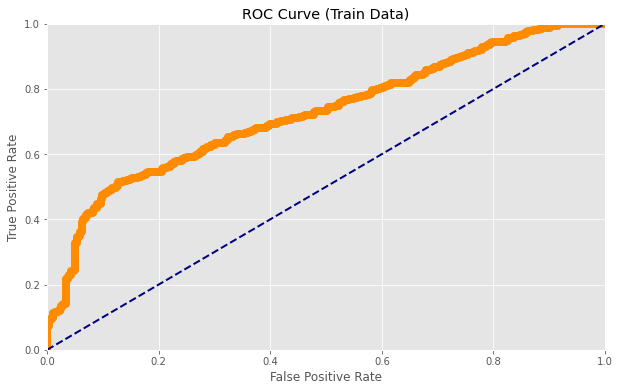

In [26]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_test, tpr_test)
plt.show()

In [27]:
# Area under ROC curve
roc_auc_score(y_test,y_scores_test)

0.7229476056338028

In [28]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,175,180,355
1,67,558,625
All,242,738,980


In [29]:
print(classification_report(y_test,y_test_predicted))

              precision    recall  f1-score   support

           0       0.72      0.49      0.59       355
           1       0.76      0.89      0.82       625

    accuracy                           0.75       980
   macro avg       0.74      0.69      0.70       980
weighted avg       0.74      0.75      0.73       980

